<a href="https://colab.research.google.com/github/JotaBlanco/Creditos_MyInvestor/blob/main/Simulaci%C3%B3n_Cr%C3%A9ditos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 - Import

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

# 02 - Import SP500

In [8]:
df_1 = pd.read_csv("https://raw.githubusercontent.com/JotaBlanco/Creditos_MyInvestor/main/data/SP500_1.csv")
df_1 = df_1[["Date", "Close"]]
df_1.columns = ["Date", "SP500"]
df_1["Date"] = pd.to_datetime(df_1["Date"])
df_1["SP500"] = df_1["SP500"].astype(float)
df_1

,Date,SP500
0,1950-01-03,16.660000
1,1950-01-04,16.850000
2,1950-01-05,16.930000
3,1950-01-06,16.980000
4,1950-01-09,17.080000
...,...,...
17213,2018-05-31,2705.270020
17214,2018-06-01,2734.620117
17215,2018-06-04,2746.870117
17216,2018-06-05,2748.800049


In [9]:
def convert_to_float(str_i):
  try:
    return float(str_i)
  except:
    return np.NaN

df_2 = pd.read_csv("https://raw.githubusercontent.com/JotaBlanco/Creditos_MyInvestor/main/data/SP500_2.csv")
df_2.columns = ["Date", "SP500"]
df_2["Date"] = pd.to_datetime(df_2["Date"])
df_2["SP500"] = [convert_to_float(str_i) for str_i in df_2["SP500"]]
df_2["SP500"] = df_2["SP500"].fillna(method='backfill')
df_2

,Date,SP500
0,2014-03-28,1857.62
1,2014-03-31,1872.34
2,2014-04-01,1885.52
3,2014-04-02,1890.90
4,2014-04-03,1888.77
...,...,...
2604,2024-03-21,5241.53
2605,2024-03-22,5234.18
2606,2024-03-25,5218.19
2607,2024-03-26,5203.58


In [10]:
df = pd.concat([df_1, df_2[df_2["Date"]>df_1["Date"].iloc[-1]]]).reset_index(drop=True)
df

,Date,SP500
0,1950-01-03,16.66
1,1950-01-04,16.85
2,1950-01-05,16.93
3,1950-01-06,16.98
4,1950-01-09,17.08
...,...,...
18728,2024-03-21,5241.53
18729,2024-03-22,5234.18
18730,2024-03-25,5218.19
18731,2024-03-26,5203.58


In [11]:
df_monthly = df.set_index("Date").resample("M").last().reset_index()
df_weekly = df.set_index("Date").resample("w").last().reset_index()

In [12]:
df["perc_max"] = df["SP500"]/df["SP500"].cummax()
df_weekly["perc_max"] = df_weekly["SP500"]/df_weekly["SP500"].cummax()
df_monthly["perc_max"] = df_monthly["SP500"]/df_monthly["SP500"].cummax()
df

,Date,SP500,perc_max
0,1950-01-03,16.66,1.000000
1,1950-01-04,16.85,1.000000
2,1950-01-05,16.93,1.000000
3,1950-01-06,16.98,1.000000
4,1950-01-09,17.08,1.000000
...,...,...,...
18728,2024-03-21,5241.53,1.000000
18729,2024-03-22,5234.18,0.998598
18730,2024-03-25,5218.19,0.995547
18731,2024-03-26,5203.58,0.992760


# 03 - Quick analysis

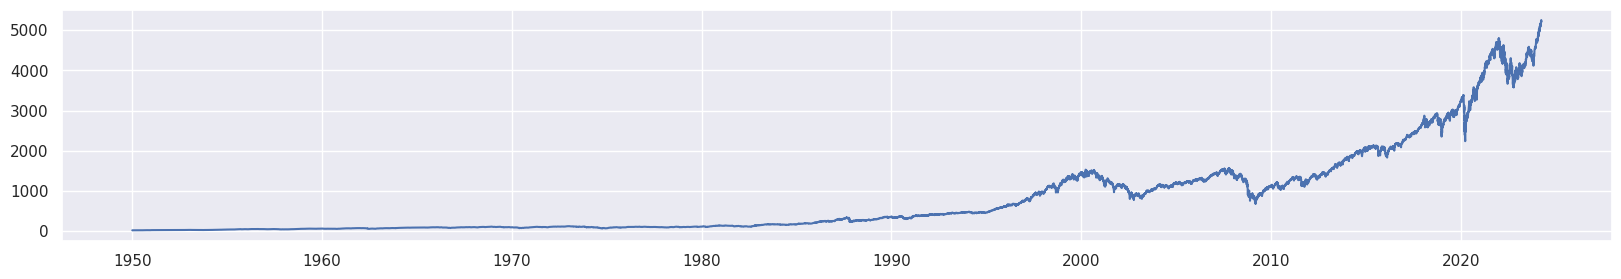

In [13]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df["Date"], df["SP500"], label="daily")
plt.show()

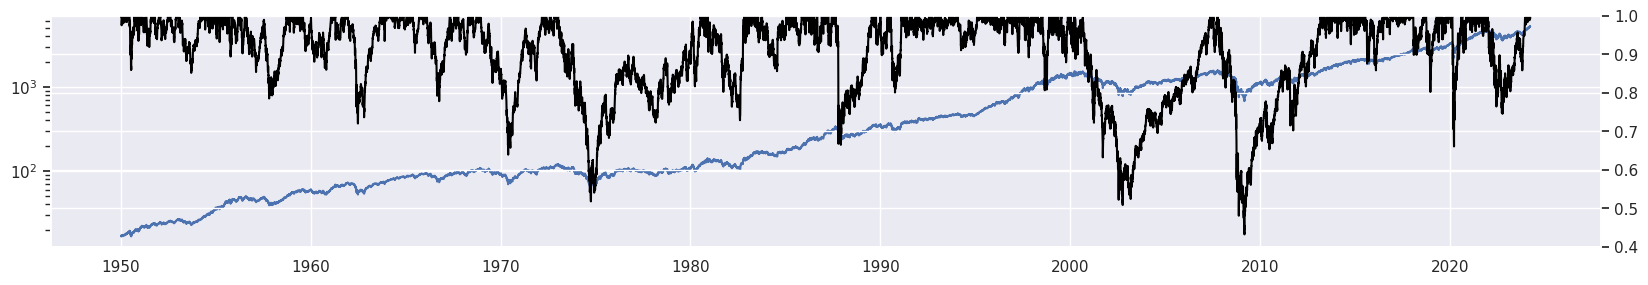

In [14]:
# Price and perc_max
fig, ax1 = plt.subplots()

ax1.plot(df["Date"], df["SP500"], label="daily")
ax2 = ax1.twinx()
ax2.plot(df["Date"], df["perc_max"], color = "black")
ax2.set_ylim(bottom=0.4, top=1)
ax1.set_yscale('log')
plt.show()

In [15]:
df["perc_max"].describe()

count    18733.000000
mean         0.903230
std          0.104844
min          0.432246
25%          0.844977
50%          0.944205
75%          0.985503
max          1.000000
Name: perc_max, dtype: float64

In [16]:
np.quantile(df["perc_max"], 0.05)

0.6949404015726482

In [17]:
(df["perc_max"]<0.7).sum()/len(df)

0.05380878663321412

In [18]:
(df["perc_max"]<0.65).sum()/len(df)

0.03320343778359046

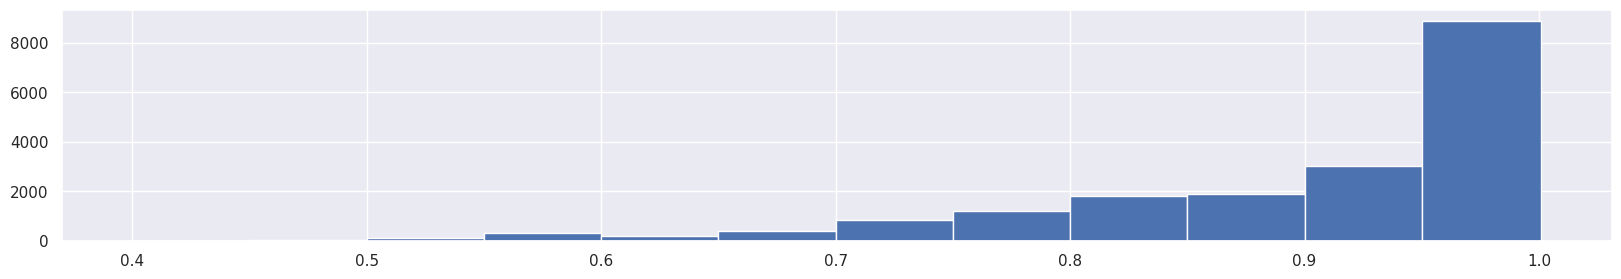

In [19]:
plt.hist(df["perc_max"], bins=[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.001])
plt.show()

# 04 - Strategies
Functions with different investment strategies

In [20]:
def simulate(df_ingresos:pd.DataFrame, df_monthly:pd.DataFrame):
  df = df_monthly.copy(deep=True)
  df = pd.concat([df, df_ingresos[["ingresos", "coste", "ingresos_ac", "coste_ac"]]], axis=1)
  df = df.dropna(subset=["ingresos"])
  df["growth"] = df["SP500"]/df["SP500"].shift(1).fillna(1)
  total = 0
  for i in range(len(df)):
    total = df.loc[i, "ingresos"] + total*df.loc[i, "growth"]
    df.loc[i, "total"] = total
  df["total"] = df["total"].astype(int)
  df["total_neto"] = df["total"]
  filter_i = df["total"] > df["ingresos_ac"]
  df.loc[filter_i,"total_neto"] = df.loc[filter_i,"ingresos_ac"] + (1-0.23)*(df.loc[filter_i,"total"]-df.loc[filter_i,"ingresos_ac"])
  return df

def get_simulation_summary(df_sim:pd.DataFrame):
  df_summary = pd.DataFrame({
      "Date_0": [df_sim["Date"].iloc[0]],
      "Date_n": [df_sim["Date"].iloc[-1]],
      "perc_max_0": [df_sim["perc_max"].iloc[0]],
      "ingresos_ac": [int(df_sim["ingresos_ac"].iloc[-1])],
      "coste_ac": [int(df_sim["coste_ac"].iloc[-1])],
      "total_bruto": [int(df_sim["total"].iloc[-1])],
      "total_neto": [int(df_sim["total_neto"].iloc[-1])]
  })
  return df_summary

def get_intereses_trimestrales(capital):
  df_intereses = pd.DataFrame({
      "Importe": [10000, 20000, 30000, 40000, 50000, 60000, 75000, 100000],
      "Int_trimestales": [102.5, 205, 307.5, 410, 512.5, 615, 768.75, 1025]
      })
  df_intereses = pd.concat([df_intereses, pd.DataFrame({"Importe": [capital], "Int_trimestales": [np.NaN]})])
  df_intereses = df_intereses.set_index("Importe").sort_index()
  df_intereses = df_intereses.interpolate(method="index")
  try:
    return df_intereses.loc[capital,"Int_trimestales"].iloc[0]
  except:
    return df_intereses.loc[capital,"Int_trimestales"]

In [21]:
def estrategia_1(recurrent_amount, months):
  """
  En la estrategia 1 se mete todos los meses una misma cantidad en el sp500
  """
  df = pd.DataFrame({
      "coste": [recurrent_amount]*months,
      "ingresos": [recurrent_amount]*months})
  df["coste_ac"] = df["coste"].cumsum()
  df["ingresos_ac"] = df["ingresos"].cumsum()
  return df

def estrategia_2(recurrent_amount, months):
  """
  En la estrategia 2 se pide prestado la máxima cantidad que se va a poder devolver
  en 5 años. Luego, durante los 5 años restantes se pagan los intereses y ahorra
  para poder devolver el capital prestado al vencimiento
  """
  loan_amount = recurrent_amount*12*5/1.205
  int_trimestral = get_intereses_trimestrales(loan_amount)
  lista_costes = [int_trimestral,0,0]*(4*5)
  lista_costes[-1] = lista_costes[-1] + loan_amount
  lista_costes = lista_costes + [recurrent_amount]*(months-12*5)
  lista_ingresos = [loan_amount] + [0]*(12*5-1) + [recurrent_amount]*(months-12*5)
  df = pd.DataFrame({"coste": lista_costes, "ingresos": lista_ingresos})
  df["coste_ac"] = df["coste"].cumsum()
  df["ingresos_ac"] = df["ingresos"].cumsum()
  return df

def estrategia_3(recurrent_amount, months):
  """
  En la estrategia 3 se pide prestado la misma cantidad que en la estrategia 2,
  para después seguir gastando mensualmente la misma cantidad que en la 1
  (la máxima disponible mensualmente), donde no todo se invierte en el sp500
  porque hay que devolver los intereses de los créditos trimestralmente.
  Al vencimiento del crédito (5 años), se pide uno nuevo para devolver el capital
  prestado inicialmente.
  """
  loan_amount = recurrent_amount*12*5/1.205
  int_trimestral = get_intereses_trimestrales(loan_amount)
  lista_costes = [recurrent_amount]*months
  lista_costes_intereses = [int_trimestral,0,0]*(months//3)
  lista_ingresos = np.array(lista_costes)-np.array(lista_costes_intereses)
  lista_ingresos[0] = lista_ingresos[0] + loan_amount
  df = pd.DataFrame({"coste": lista_costes, "ingresos": lista_ingresos})
  df["coste_ac"] = df["coste"].cumsum()
  df["ingresos_ac"] = df["ingresos"].cumsum()
  return df

# 05 - Simulations

In [36]:
def perform_sim(años, coste_anual_deseado):
  recurrente = coste_anual_deseado/12
  months = 12*años
  loan_amount = recurrente*12*5/1.205

  df_1 = estrategia_1(recurrente, months)
  df_2 = estrategia_2(recurrente, months)
  df_3 = estrategia_3(recurrente, months)

  df_all_sim = pd.DataFrame()
  for i in range(len(df_monthly)-12*años):
    df_montly_i = df_monthly.iloc[i:i+12*años]

    df_1_i = get_simulation_summary(simulate(df_1, df_montly_i.reset_index(drop=True)))
    df_1_i.columns = ['Date_0', 'Date_n', 'perc_max_0',
                      'ingresos_ac_1', 'coste_ac_1', 'total_bruto_1', 'total_neto_1']

    df_2_i = get_simulation_summary(simulate(df_2, df_montly_i.reset_index(drop=True)))
    df_2_i.columns = ['Date_0', 'Date_n', 'perc_max_0',
                      'ingresos_ac_2', 'coste_ac_2', 'total_bruto_2', 'total_neto_2']

    df_3_i = get_simulation_summary(simulate(df_3, df_montly_i.reset_index(drop=True)))
    df_3_i.columns = ['Date_0', 'Date_n', 'perc_max_0',
                      'ingresos_ac_3', 'coste_ac_3', 'total_bruto_3', 'total_neto_3']

    df_i = pd.merge(df_1_i, df_2_i, how="left", on=["Date_0","Date_n","perc_max_0"])
    df_i = pd.merge(df_i, df_3_i, how="left", on=["Date_0","Date_n","perc_max_0"])

    df_all_sim = pd.concat([df_all_sim, df_i], axis=0).reset_index(drop=True)

  df_all_sim["total_neto_3"] = df_all_sim["total_neto_3"] - loan_amount
  df_all_sim["total_neto_3"] = df_all_sim["total_neto_3"].astype(int)
  return df_all_sim

In [34]:
# PERFORM SIMULATION
# will take some minutes
coste_anual_deseado = 12000
dic_all = {}
for años_i in [5, 10, 15, 20, 25]:
  print("Simulando estrategias a "+str(años_i)+" años...")
  df_all_sim = perform_sim(años_i, coste_anual_deseado)
  dic_all[años_i] = df_all_sim

Años: 5...
Años: 10...
Años: 15...
Años: 20...
Años: 25...


# 06 - Plotting results

In [45]:
range(1,60)

range(1, 60)

In [46]:
def plot_results(años, df_ii, threshold=0.7):
  print("Distribución de los resultados")
  cols = ['perc_max_0', 'coste_ac_1', 'total_neto_1', 'total_neto_2', 'total_neto_3']
  display(df_ii[cols].describe())
  print()

  plt.rcParams["figure.figsize"] = (10,5)
  p = sns.kdeplot(data=df_ii["total_neto_1"], label="Estrategia 1", color="black")
  p = sns.kdeplot(data=df_ii["total_neto_2"], label="Estrategia 2", color="orange")
  p = sns.kdeplot(data=df_ii["total_neto_3"], label="Estrategia 3", color="navy")
  ticks = max(p.get_yticks())  # get the max value of the y-ticks
  p.vlines(x=np.mean(df_ii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red', label="Coste")
  plt.xlim(left=min(df_ii["total_neto_3"]), right=max(df_ii["total_neto_3"]))
  plt.title(str(años)+" AÑOS")
  plt.legend()
  plt.show()
  print()

  print("Distribución de los resultados con threshold de entrada de {}".format(threshold))
  filter_i = df_ii["perc_max_0"] < threshold
  df_iii = df_ii[filter_i]
  display(df_iii[cols].describe())

  plt.rcParams["figure.figsize"] = (10,5)
  p = sns.kdeplot(data=df_iii["total_neto_1"], label="Estrategia 1", color="black")
  p = sns.kdeplot(data=df_iii["total_neto_2"], label="Estrategia 2", color="orange")
  p = sns.kdeplot(data=df_iii["total_neto_3"], label="Estrategia 3", color="navy")
  ticks = max(p.get_yticks())  # get the max value of the y-ticks
  p.vlines(x=np.mean(df_iii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red', label="Coste")
  plt.xlim(left=min(df_ii["total_neto_3"]), right=max(df_ii["total_neto_3"]))
  plt.title(str(años)+" AÑOS only investing under {}".format(threshold))
  plt.legend()
  plt.show()
  print()


def plot_strategies(df_1, df_2, df_3):

  plt.rcParams["figure.figsize"] = (10, 2.5)
  plt.plot((df_1.index+1)/12, df_1["ingresos_ac"], label="Estrategia 1", color="black")
  plt.plot((df_2.index+1)/12, df_2["ingresos_ac"], label="Estrategia 2", color="orange")
  plt.plot((df_3.index+1)/12, df_3["ingresos_ac"], label="Estrategia 3", color="navy")
  plt.legend()
  plt.title("Ingresos en el SP500")
  plt.xlabel("Años")
  plt.show()

  plt.plot((df_1.index+1)/12, df_1["coste_ac"], label="Estrategia 1", color="black")
  plt.plot((df_2.index+1)/12, df_2["coste_ac"], label="Estrategia 2", color="orange")
  plt.plot((df_3.index+1)/12, df_3["coste_ac"], label="Estrategia 3", color="navy")
  plt.legend()
  plt.title("Coste total")
  plt.xlabel("Años")
  plt.show()


AÑOS:  5



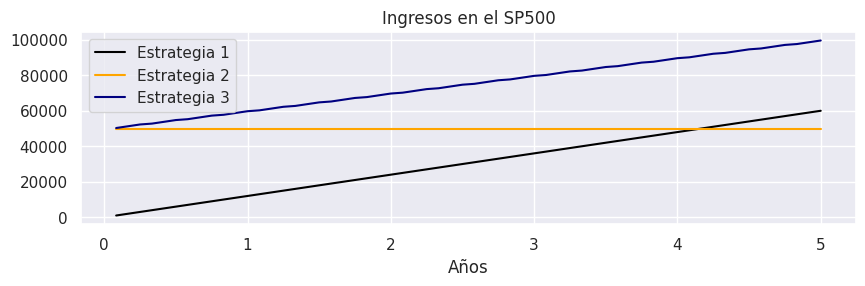

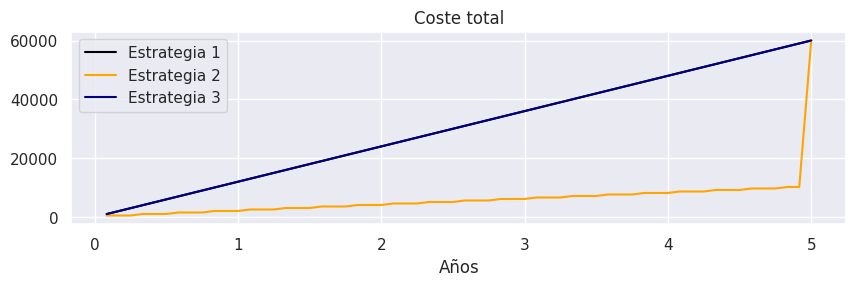

Distribución de los resultados


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,831.000000,831.0,831.000000,831.000000,831.000000
mean,0.910240,60000.0,70662.761733,68862.020457,77696.052948
std,0.106913,0.0,10668.125572,17913.021458,25947.509370
min,0.474441,60000.0,35810.000000,32500.000000,12512.000000
25%,0.851766,60000.0,64475.500000,55389.000000,58679.500000
50%,0.953779,60000.0,71060.000000,68573.000000,77249.000000
75%,1.000000,60000.0,75472.500000,79200.500000,91311.500000
max,1.000000,60000.0,102066.000000,131198.000000,161940.000000


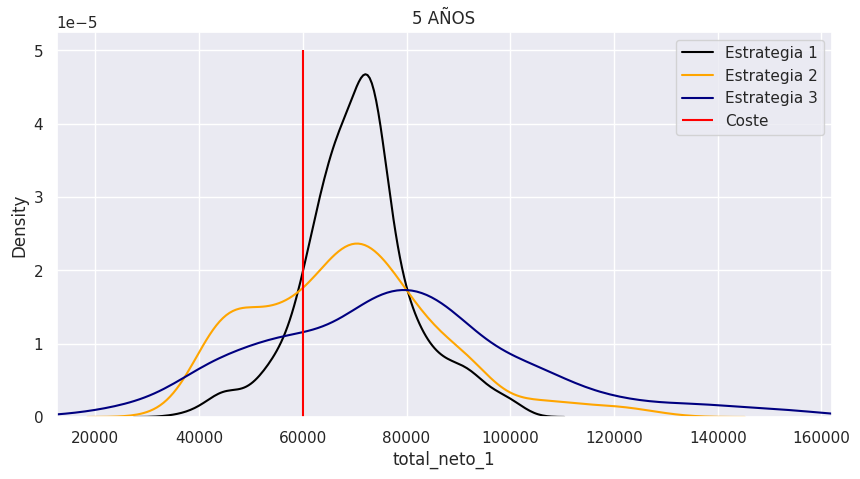


Distribución de los resultados con threshold de entrada de 0.7


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,46.000000,46.0,46.000000,46.000000,46.000000
mean,0.620733,60000.0,71454.934783,75360.239130,84804.695652
std,0.056273,0.0,8620.450461,13050.138121,19619.622079
min,0.474441,60000.0,46038.000000,45583.000000,34032.000000
25%,0.581322,60000.0,65380.750000,66556.500000,70143.250000
50%,0.625628,60000.0,72061.000000,74787.000000,85001.500000
75%,0.667893,60000.0,79831.500000,84827.250000,102033.500000
max,0.698302,60000.0,83327.000000,104426.000000,120733.000000


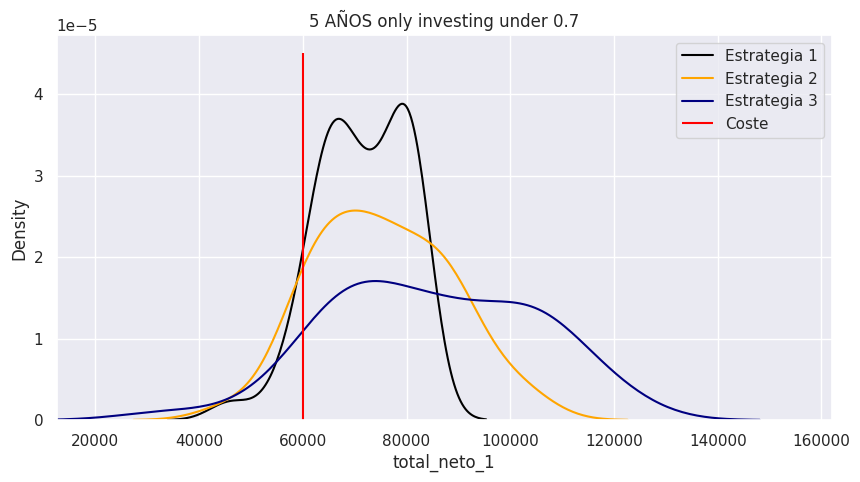





AÑOS:  10



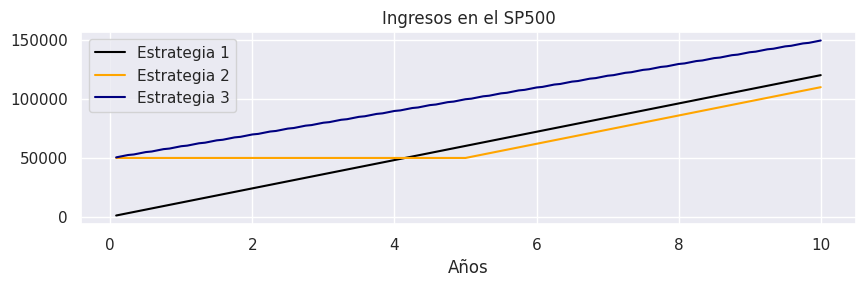

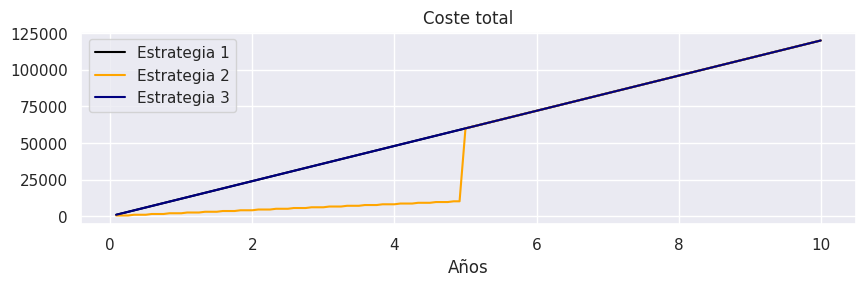

Distribución de los resultados


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,771.000000,771.0,771.000000,771.000000,771.000000
mean,0.904840,120000.0,166968.573281,164991.011673,183551.691310
std,0.108845,0.0,36629.272965,41087.211315,62023.056633
min,0.474441,120000.0,74494.000000,64264.000000,40531.000000
25%,0.844291,120000.0,139628.000000,135149.500000,138030.500000
50%,0.946517,120000.0,167463.000000,159316.000000,174821.000000
75%,0.998693,120000.0,189748.000000,193441.000000,225991.500000
max,1.000000,120000.0,279728.000000,290187.000000,372846.000000


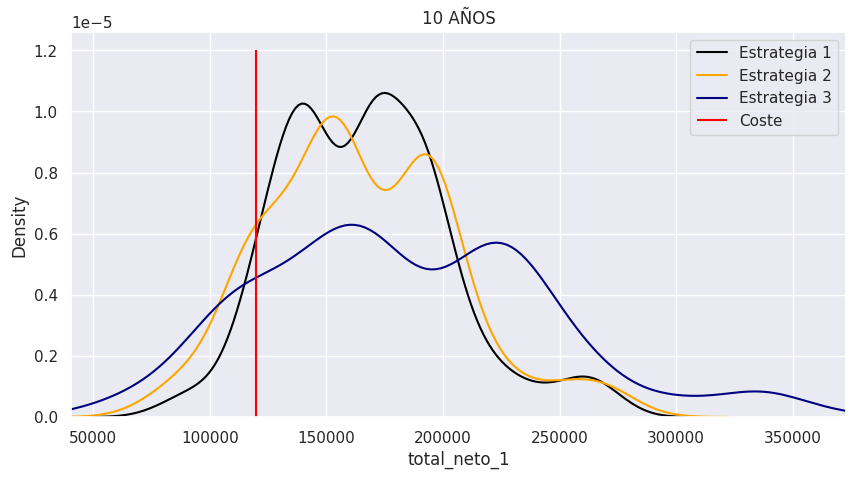


Distribución de los resultados con threshold de entrada de 0.7


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,46.000000,46.0,46.000000,46.000000,46.000000
mean,0.620733,120000.0,164005.021739,170613.717391,184604.652174
std,0.056273,0.0,23650.880074,30658.791029,47709.627698
min,0.474441,120000.0,119789.000000,110531.000000,102036.000000
25%,0.581322,120000.0,144801.250000,150919.000000,148781.250000
50%,0.625628,120000.0,161219.000000,162429.500000,176394.500000
75%,0.667893,120000.0,185240.750000,196088.250000,228795.500000
max,0.698302,120000.0,232413.000000,254145.000000,306426.000000


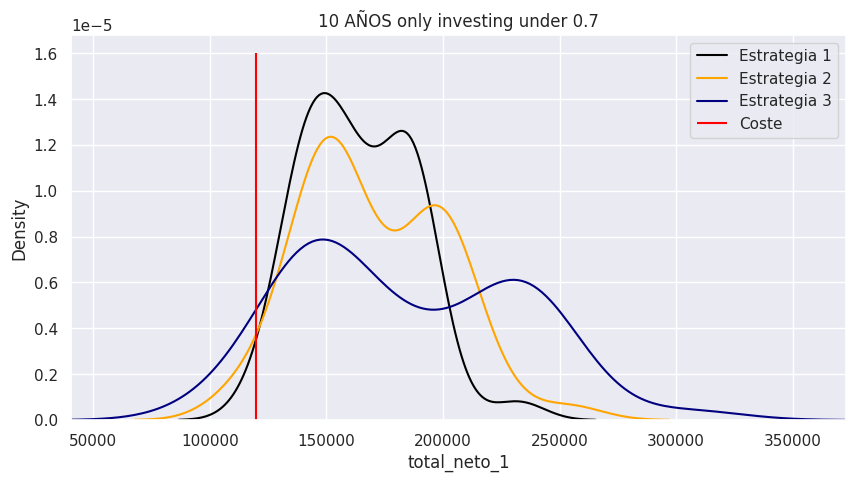





AÑOS:  15



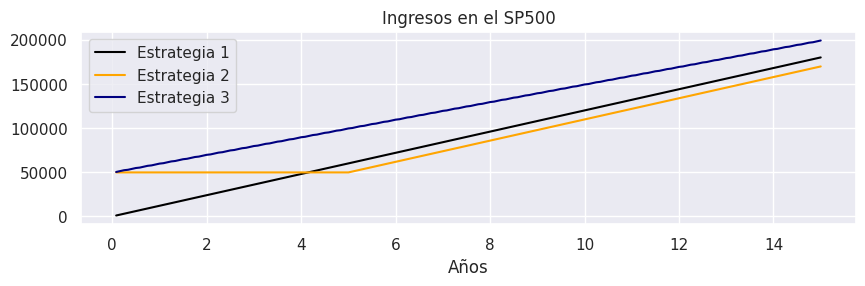

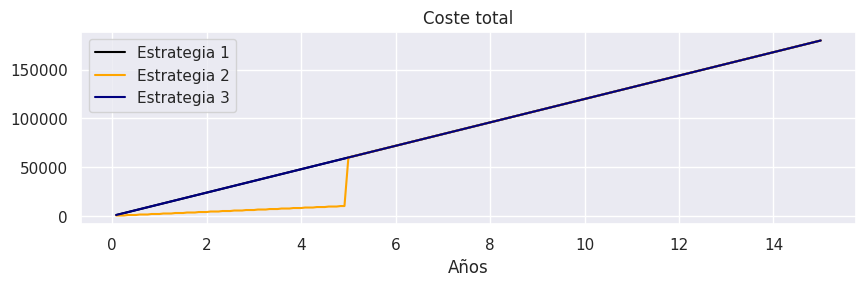

Distribución de los resultados


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,711.000000,711.0,711.000000,711.000000,711.000000
mean,0.910735,180000.0,299828.654008,296241.067511,328743.473980
std,0.105302,0.0,87528.532003,93378.759250,131039.142795
min,0.474441,180000.0,139365.000000,136748.000000,121871.000000
25%,0.851782,180000.0,231918.000000,225407.000000,222383.000000
50%,0.951608,180000.0,285787.000000,286410.000000,322366.000000
75%,0.999750,180000.0,354794.500000,344070.000000,408252.500000
max,1.000000,180000.0,563006.000000,637508.000000,776913.000000


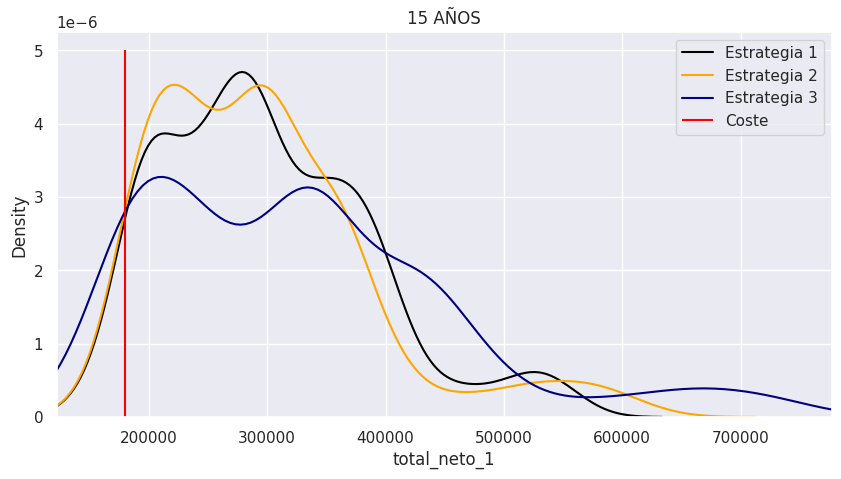


Distribución de los resultados con threshold de entrada de 0.7


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,36.000000,36.0,36.000000,36.000000,36.000000
mean,0.614476,180000.0,334054.166667,344577.944444,379536.805556
std,0.058080,0.0,42764.103324,54254.032424,80161.605129
min,0.474441,180000.0,274479.000000,260452.000000,269172.000000
25%,0.579398,180000.0,301936.000000,307730.750000,320691.500000
50%,0.614058,180000.0,314894.500000,323777.000000,338733.000000
75%,0.658228,180000.0,378010.750000,390439.250000,462404.000000
max,0.698302,180000.0,406970.000000,452526.000000,533339.000000


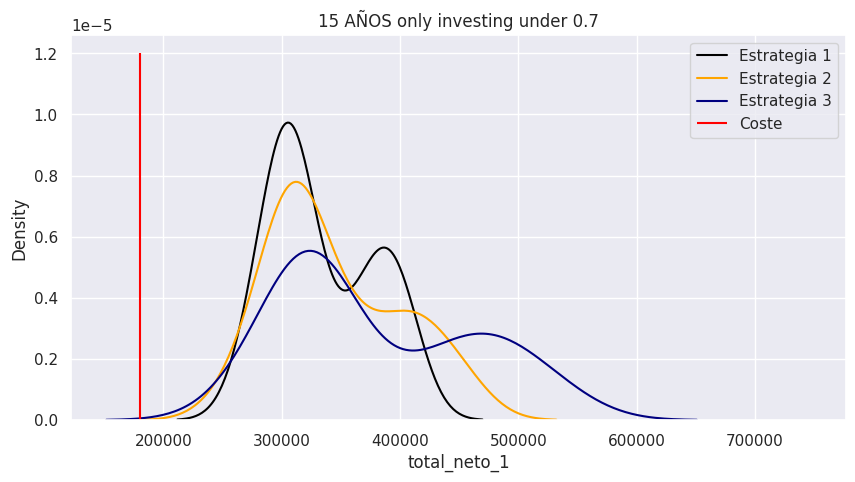





AÑOS:  20



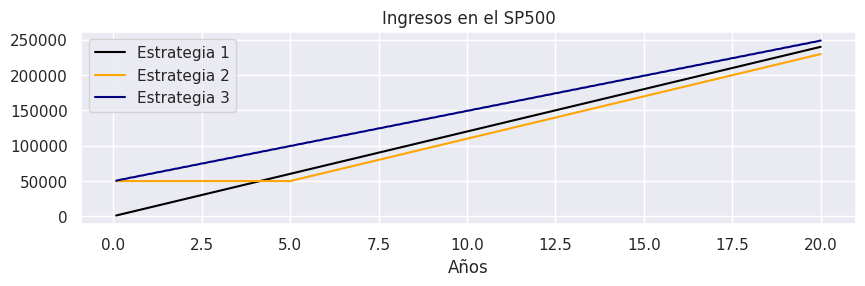

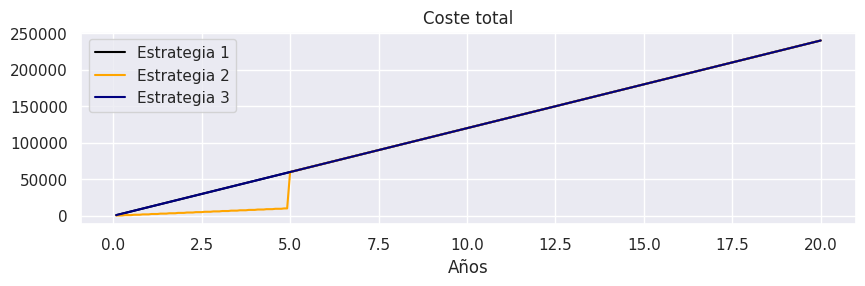

Distribución de los resultados


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,651.000000,651.0,6.510000e+02,6.510000e+02,6.510000e+02
mean,0.919072,240000.0,4.825251e+05,4.787218e+05,5.293274e+05
std,0.099990,0.0,1.799358e+05,1.766585e+05,2.416160e+05
min,0.537188,240000.0,2.250700e+05,2.379840e+05,2.281150e+05
25%,0.868018,240000.0,3.504175e+05,3.506875e+05,3.648015e+05
50%,0.960337,240000.0,4.430000e+05,4.380500e+05,4.637960e+05
75%,1.000000,240000.0,5.652920e+05,5.494870e+05,6.088875e+05
max,1.000000,240000.0,1.080887e+06,1.108691e+06,1.390261e+06


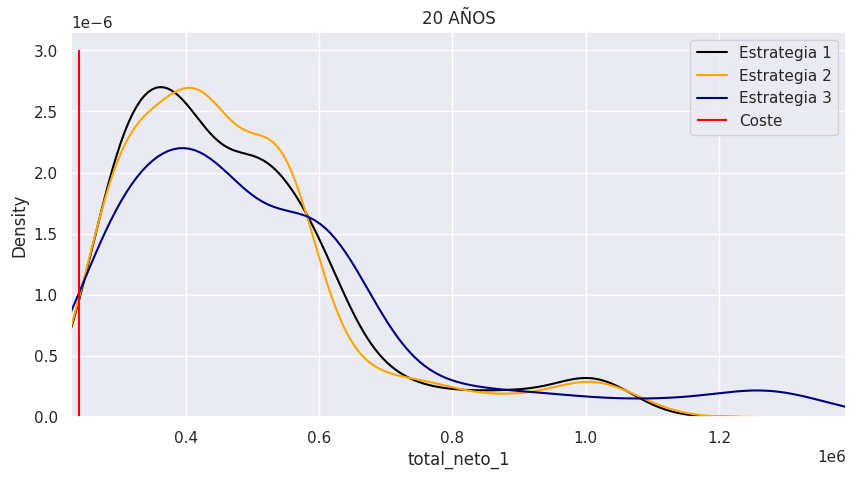


Distribución de los resultados con threshold de entrada de 0.7


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,30.000000,30.0,30.000000,30.000000,30.000000
mean,0.627067,240000.0,547379.033333,556705.800000,607263.800000
std,0.050773,0.0,36128.629395,37075.773592,60104.555368
min,0.537188,240000.0,476151.000000,486554.000000,511773.000000
25%,0.585899,240000.0,522508.250000,532688.500000,562002.250000
50%,0.630458,240000.0,548333.000000,553089.000000,588968.000000
75%,0.669320,240000.0,577470.750000,575360.750000,654535.250000
max,0.698302,240000.0,619360.000000,655282.000000,749846.000000


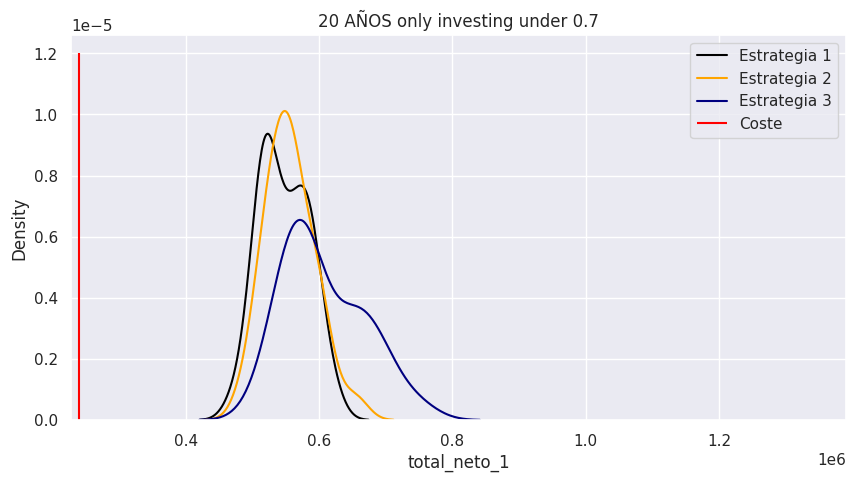





AÑOS:  25



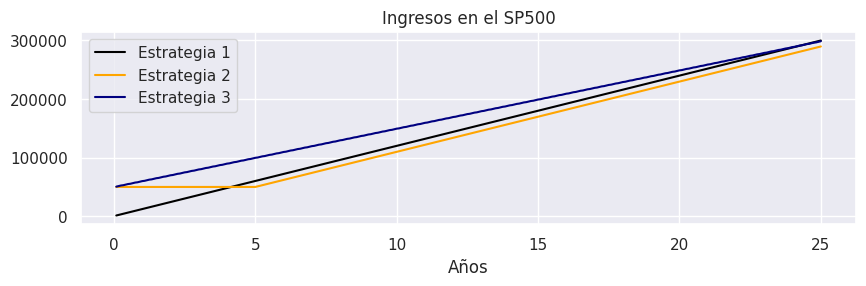

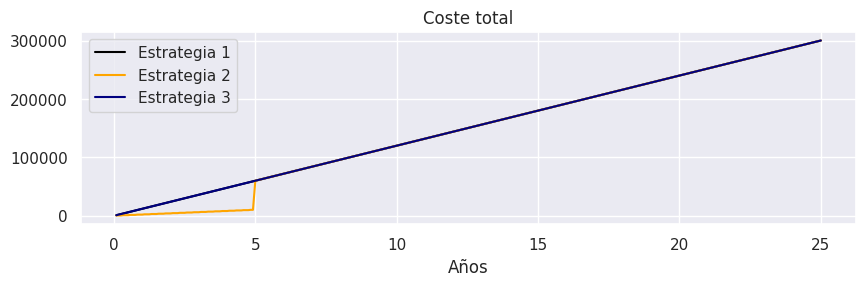

Distribución de los resultados


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,591.000000,591.0,5.910000e+02,5.910000e+02,5.910000e+02
mean,0.932403,300000.0,7.511516e+05,7.454137e+05,8.251027e+05
std,0.082997,0.0,3.084952e+05,2.877286e+05,3.689088e+05
min,0.538247,300000.0,3.713550e+05,3.697110e+05,3.604870e+05
25%,0.883918,300000.0,5.300955e+05,5.375945e+05,5.914795e+05
50%,0.966177,300000.0,6.605350e+05,6.750540e+05,7.203560e+05
75%,1.000000,300000.0,8.669600e+05,8.700765e+05,9.952490e+05
max,1.000000,300000.0,1.796664e+06,1.824107e+06,2.181949e+06


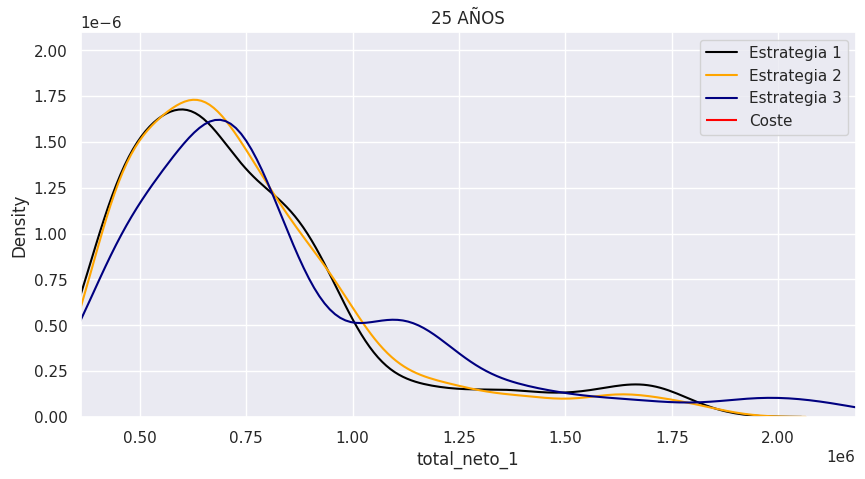


Distribución de los resultados con threshold de entrada de 0.7


,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,10.000000,10.0,1.000000e+01,1.000000e+01,1.000000e+01
mean,0.633333,300000.0,1.513438e+06,1.558971e+06,1.841532e+06
std,0.052512,0.0,4.239679e+05,4.344962e+05,5.455840e+05
min,0.538247,300000.0,5.523250e+05,5.871560e+05,6.543940e+05
25%,0.597332,300000.0,1.632272e+06,1.661928e+06,1.980954e+06
50%,0.639051,300000.0,1.698010e+06,1.743978e+06,2.084492e+06
75%,0.671634,300000.0,1.713132e+06,1.811140e+06,2.139915e+06
max,0.698302,300000.0,1.796664e+06,1.824107e+06,2.181949e+06


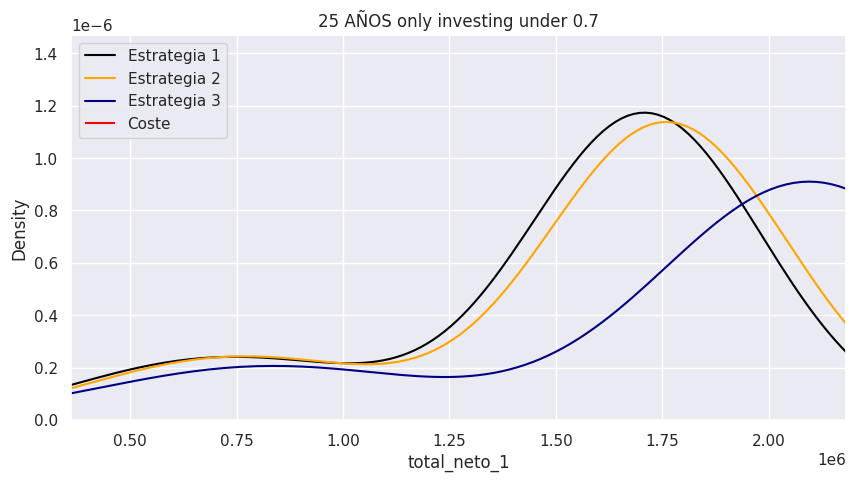

In [48]:
for años_i in dic_all:
  recurrente = coste_anual_deseado/12
  months = 12*años_i

  df_1 = estrategia_1(recurrente, months)
  df_2 = estrategia_2(recurrente, months)
  df_3 = estrategia_3(recurrente, months)

  print()
  print("AÑOS: ", años_i)
  print()
  plot_strategies(df_1, df_2, df_3)
  plot_results(
      años = años_i,
      df_ii = dic_all[años_i],
      threshold = 0.7)
  print()
  print()

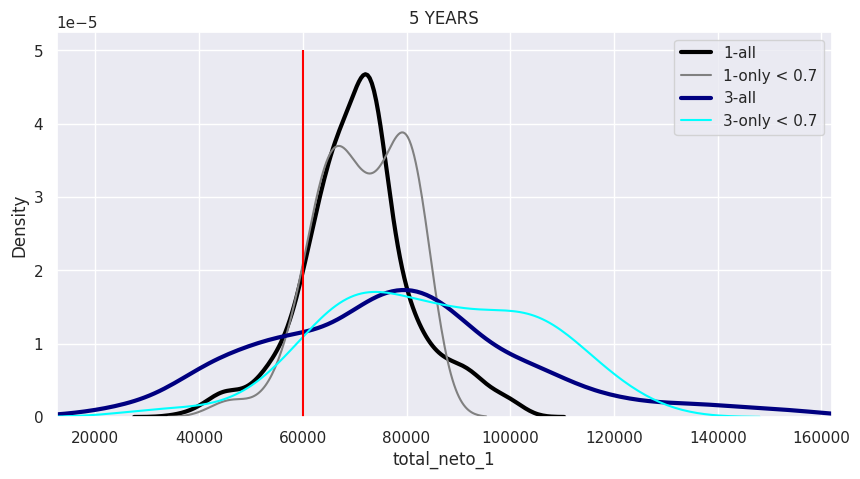

In [55]:
threshold = 0.7
años = 5
plt.rcParams["figure.figsize"] = (10,5)
df_ii = dic_all[años]
filter_i = df_ii["perc_max_0"] < threshold
df_iii = df_ii[filter_i]
p = sns.kdeplot(data=df_ii["total_neto_1"], label = "1-all", color="black", linewidth = 3)
p = sns.kdeplot(data=df_iii["total_neto_1"], label = "1-only < {}".format(threshold), color="grey")
p = sns.kdeplot(data=df_ii["total_neto_3"], label = "3-all", color="navy", linewidth=3)
p = sns.kdeplot(data=df_iii["total_neto_3"], label = "3-only < {}".format(threshold), color="aqua")
ticks = max(p.get_yticks())  # get the max value of the y-ticks
p.vlines(x=np.mean(df_ii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
plt.xlim(left=min(min(df_ii["total_neto_1"]),min(df_ii["total_neto_3"])), right=max(df_ii["total_neto_3"]))
plt.title(str(años)+" YEARS")
plt.legend()
plt.show()


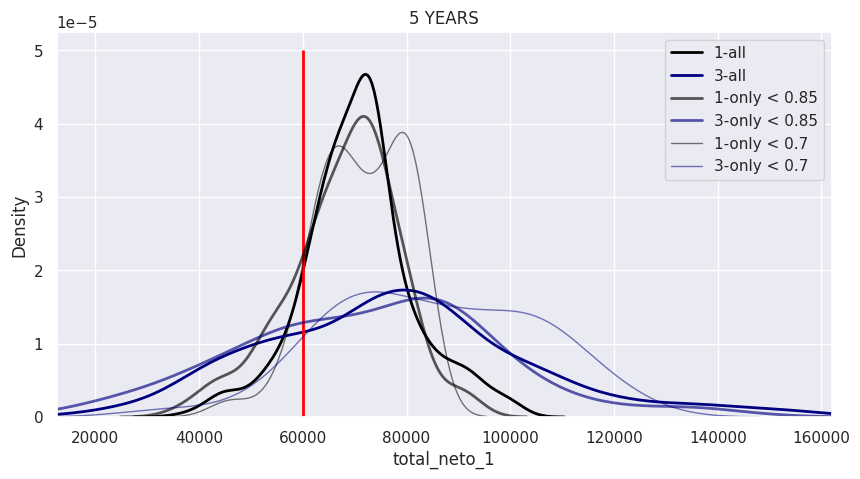

In [52]:
thresholds = [0.9,0.8,0.7,0.6]
thresholds = [0.85,0.7]
años = 5
df_ii = dic_all[años]

plt.rcParams["figure.figsize"] = (10,5)
p = sns.kdeplot(data=df_ii["total_neto_1"], label = "1-all", color="black", linewidth=len(thresholds))
p = sns.kdeplot(data=df_ii["total_neto_3"], label = "3-all", color="navy", linewidth=len(thresholds))
ticks = max(p.get_yticks())  # get the max value of the y-ticks
p.vlines(x=np.mean(df_ii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red', linewidth=2)
for i, threshold_i in enumerate(thresholds):
  filter_i = df_ii["perc_max_0"] < threshold_i
  df_iii = df_ii[filter_i]
  p = sns.kdeplot(
      data=df_iii["total_neto_1"],
      label = "1-only < {}".format(threshold_i),
      color="black", alpha=threshold_i*0.75,
      linewidth=len(thresholds)-i)
  p = sns.kdeplot(
      data=df_iii["total_neto_3"],
      label = "3-only < {}".format(threshold_i),
      color="navy", alpha=threshold_i*0.75,
      linewidth=len(thresholds)-i)

plt.xlim(left=min(min(df_ii["total_neto_1"]),min(df_ii["total_neto_3"])), right=max(df_ii["total_neto_3"]))
plt.title(str(años)+" YEARS")
plt.legend()
plt.show()